# Practical Neighbourhood Connection to the Grid

#### Importing the needed packages
The first step in every python notebook is to install the needed packages (e.g. [`pandas`](https://pandas.pydata.org/docs/user_guide/index.html) for data management) as well as functions and classes from external scripts.

In [1]:
from illuminator.engine import Simulation
import functions_T3
import pandas as pd
import nest_asyncio
nest_asyncio.apply()

#### Setting
A neighbourhood of 10 houses is connected to the grid (see the picture below). This connection to the grid has a capacity of 15 kW.

![T3_basecase](Graphics_T3/neighbourhood_T3_base_case.png)

#### Task 1: Load on Connection in case of Conventional Energy Supply

In this task there is no local production of electricity in the neighbourhood. Therefore,  neighbourhood's demand needs to be completely fulfilled by electricity from the grid.

In the code below a pandas dataframe load_df is created from a txt file which entails the load data of the neighbourhood. Then the days of interest in summer(day_summer) and winter(day_winter) are selected. Afterwards the size of the neighbourhood is specified with the number_of_houses parameter and the connection capacity is set with the connection_cap parameter. For this exercise it is assumed that a load between 67% and 90% of the connection capacity is within the tolerance region, whereas a load above 90% is critical. This is expressed with the tolerance_limit and critical_limit parameters. The load on the connection is then plotted with the plot_load_on_connection() function.


Run the code below and observe the load at the connection for the two selected days (2012-02-01 and 2012-07-06).

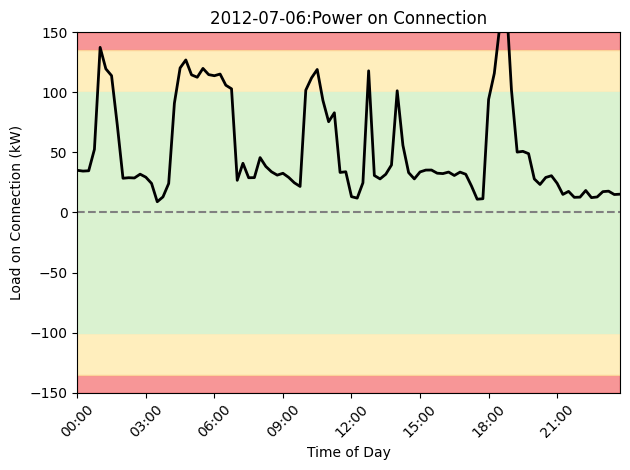

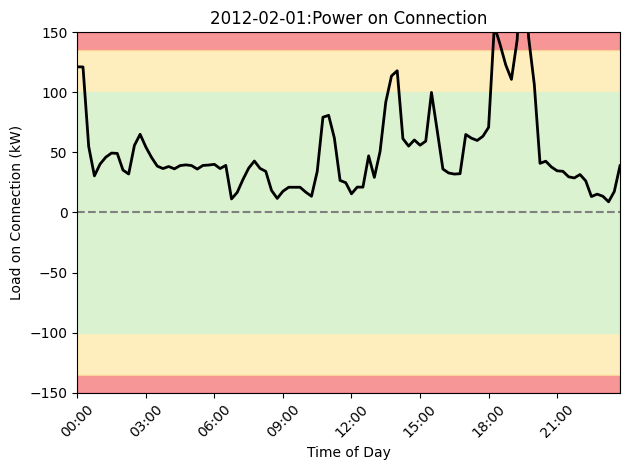

In [5]:
# Scenario Data 
load_df = pd.read_csv('data/load_data.txt', delimiter=',', header = 0,skiprows=1) # Load Profile
load_df['time'] = pd.to_datetime(load_df['time'])
load_df.set_index('time', inplace=True)

day_summer = '2012-07-06'
day_winter = '2012-02-01'

number_of_houses = 150 # size of the neighbourhood
connection_cap = 150 # capacity of the connection in kW
tolerance_limit = 0.67 # a load on the connection between 67% and 90% is tolerable but causes a warning
critical_limit = 0.9 # a load on the connection over 90% of the connection capacity is critical

# Plot the Load on the connection
functions_T3.plot_load_on_connection(load_df, day_summer, number_of_houses, tolerance_limit, critical_limit, connection_cap)
functions_T3.plot_load_on_connection(load_df, day_winter, number_of_houses, tolerance_limit, critical_limit, connection_cap)

#### Task 2: Local Renewable Generation and Storage Solutions

To be more sustainable the neighbourhood decides to install solar panels on the roofs and a small-scale wind turbine.

![T3_REScase](Graphics_T3/neighbourhood_T3_RES_case.png)


##### 2a) Integrating local Renewable Generation
In the code the simulation is set up with the 'Tutorial_physical_congestion_RES.yaml' file. For this simulation a Solar, Wind and Load model are utilized. Additionally CSV reader models (e.g. 'CSVload') enable loading the necessary inputs in each time step. The parameters of the models can be adjusted with the edit_models() function that updates the models based on the new_settings parameter. Additionally, the start and end time can be varied with the set_scenario_param() of the simulation. After running the simulation you can visualize the results with the plot_results_connection() function. This function loads the result from the './out_Tutorial_RES.csv' with is created and replaced every time you run the simulation. Therefore, always plot the results of a certain simulation before running a new scenario.


- Run the simulation below for the two chosen days. What do you observe and how does it compare to the case with conventional energy supply (task 1)? How does the installation of local renewables in the neighbourhood affect the load at the connection to the grid? Explain your observations.
- Vary the installed renewable capacity with the 'p_rated' (unit kW) parameter of the Wind model and the 'cap' (unit W) parameter of the Solar model according to the scenarios below and your own examples.

![T3_REScase_scen](Graphics_T3/table_scenarios_RES.png)

In [3]:
%%capture
CONFIG_FILE = 'Tutorial_physical_congestion_RES.yaml'
simulation_RES = Simulation(CONFIG_FILE)
simulation_RES.set_model_param(model_name='CSVload', parameter='file_path', value='data/load_data.txt')
simulation_RES.set_model_param(model_name='CSV_pv', parameter='file_path',
                                   value='data/pv_data_Rotterdam_NL-15min.txt')
simulation_RES.set_model_param(model_name='CSV_wind', parameter='file_path', value='data/winddata_NL.txt')

new_settings = {'Wind1': {'p_rated': 10}, #installed wind capacity in kW
                'Load1': {'houses': 10}, #number of houses
                'PV1': {'cap': 20000}, #installed solar capacity in W
                'Grid1':{'connection_capacity' : 15, 'tolerance_limit': 0.67, 'critical_limit': 0.9}, # connection capacity in kW and limits of the connection
                }

simulation_RES.edit_models(new_settings)

# you can switch between the selected days 2012-02-01 and 2012-07-06 by changing the date in the two lines below for better readibility it is advised to keep the observed time slot at 1 day
simulation_RES.set_scenario_param('start_time', '2012-02-01 00:00:00')
simulation_RES.set_scenario_param('end_time', '2012-02-01 23:45:00')

# run the simulation
simulation_RES.run()

2025-05-19 12:15:51.351 | INFO     | mosaik.scenario:start:311 - Starting "Collector" as "Collector-0" ...
2025-05-19 12:15:52.531 | INFO     | mosaik.scenario:start:311 - Starting "CSVload" as "CSVload-0" ...
2025-05-19 12:15:52.649 | INFO     | mosaik.scenario:start:311 - Starting "CSV_pv" as "CSV_pv-0" ...
2025-05-19 12:15:52.749 | INFO     | mosaik.scenario:start:311 - Starting "CSV_wind" as "CSV_wind-0" ...
2025-05-19 12:15:52.850 | INFO     | mosaik.scenario:start:311 - Starting "Grid1" as "Grid1-0" ...
2025-05-19 12:15:52.850 | INFO     | mosaik.scenario:start:311 - Starting "Load1" as "Load1-0" ...
2025-05-19 12:15:52.850 | INFO     | mosaik.scenario:start:311 - Starting "PV1" as "PV1-0" ...
2025-05-19 12:15:52.850 | INFO     | mosaik.scenario:start:311 - Starting "Wind1" as "Wind1-0" ...
2025-05-19 12:15:52.850 | INFO     | mosaik.scenario:start:311 - Starting "Controller1" as "Controller1-0" ...
2025-05-19 12:15:52.850 | INFO     | mosaik.scenario:run:651 - Starting simulatio

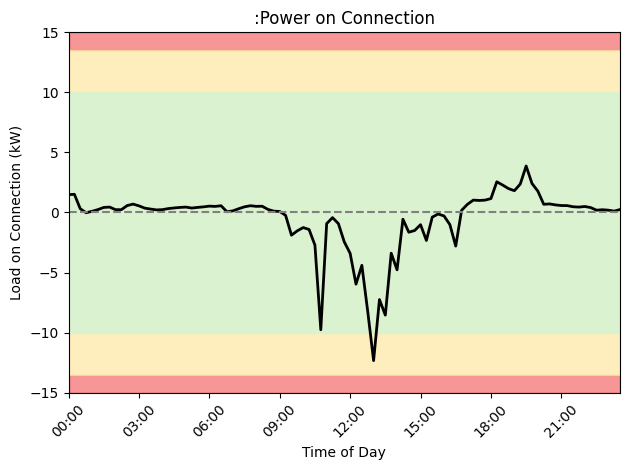

In [4]:
# the following function plots the load at the connection for the simulated day
functions_T3.plot_results_connection('./out_Tutorial_RES.csv', connection_cap = 15, critical_limit = 0.9, tolerance_limit = 0.67)

An overload at the connection to the grid can lead to damage of components, infrastructure and connected devices. Additionally, the reliability of the grid decreases if the load at the connection is frequently exceeding the capacity and blackouts can occur. Are overloads a problem in the case at hand? And what could be options to avoid overloads?

##### 2b) Local Renewables & Local Battery Storage
To utilize the local renewable generation more efficiently the neighbourhood decides to invest in a local community battery storage. The new set up file 'Tutorial_physical_congestion_RES_bat.yaml' therefore also includes a battery model. The parameter of the battery model can now also be adjusted with the new_settings dictionary. To adjust the battery capacity vary 'max_p' and 'min_p' for the 'Battery1' model and 'max_p' for the 'Controller1' model.

- Run the code below to simulate the new situation for the two chosen days (winter 2012-02-01 and summer day 2012-07-06). What is the impact of the battery on the load on the connection for the winter and the summer day?
- Vary the capacity of communal battery and observe the effect of the load on the connection. Test at least the following scenarios:

    'max_p' = 10, 'min_p' = -10

    'max_p' = 20, 'min_p' = -20

    'max_p' = 60, 'min_p' = -60

    Remember to also ajust the respective 'max_p' input of the controller for consistent results.

- Test the Scenarios from 2a) for the installed capacity of the wind and solar model with the different capacities of the communal battery.

In [14]:
%%capture
CONFIG_FILE = 'Tutorial_physical_congestion_RES_bat.yaml'
simulation_RES_Bat = Simulation(CONFIG_FILE)
simulation_RES_Bat.set_model_param(model_name='CSVload', parameter='file_path', value='data/load_data.txt')
simulation_RES_Bat.set_model_param(model_name='CSV_pv', parameter='file_path',
                                   value='data/pv_data_Rotterdam_NL-15min.txt')
simulation_RES_Bat.set_model_param(model_name='CSV_wind', parameter='file_path', value='data/winddata_NL.txt')

new_settings = {'Wind1': {'p_rated': 10},
                'Load1': {'houses': 10},
                'PV1': {'cap': 20000},
                'Battery1': {'max_p': 40, 'min_p': -40, 'soc_min': 10, 'soc_max': 90},
                'Controller1': {'battery_active': True,'max_p': 40},
                'Grid1':{'connection_capacity' : 15, 'tolerance_limit': 0.67, 'critical_limit': 0.9},
                }

simulation_RES_Bat.edit_models(new_settings)

# you can switch between the selected days 2012-02-01 and 2012-07-06 by changing the date in the two lines below for better readibility it is advised to keep the observed time slot at 1 day
simulation_RES_Bat.set_scenario_param('start_time', '2012-02-01 00:00:00')
simulation_RES_Bat.set_scenario_param('end_time', '2012-02-01 23:45:00')

# run the simulation
simulation_RES_Bat.run()


2025-03-14 10:03:13.291 | INFO     | mosaik.scenario:start:311 - Starting "Collector" as "Collector-0" ...
2025-03-14 10:03:14.250 | INFO     | mosaik.scenario:start:311 - Starting "CSVload" as "CSVload-0" ...
2025-03-14 10:03:14.371 | INFO     | mosaik.scenario:start:311 - Starting "CSV_pv" as "CSV_pv-0" ...
2025-03-14 10:03:14.484 | INFO     | mosaik.scenario:start:311 - Starting "CSV_wind" as "CSV_wind-0" ...
2025-03-14 10:03:14.602 | INFO     | mosaik.scenario:start:311 - Starting "Grid1" as "Grid1-0" ...
2025-03-14 10:03:14.603 | INFO     | mosaik.scenario:start:311 - Starting "Load1" as "Load1-0" ...
2025-03-14 10:03:14.604 | INFO     | mosaik.scenario:start:311 - Starting "PV1" as "PV1-0" ...
2025-03-14 10:03:14.607 | INFO     | mosaik.scenario:start:311 - Starting "Wind1" as "Wind1-0" ...
2025-03-14 10:03:14.609 | INFO     | mosaik.scenario:start:311 - Starting "Battery1" as "Battery1-0" ...
2025-03-14 10:03:14.610 | INFO     | mosaik.scenario:start:311 - Starting "Controller1"

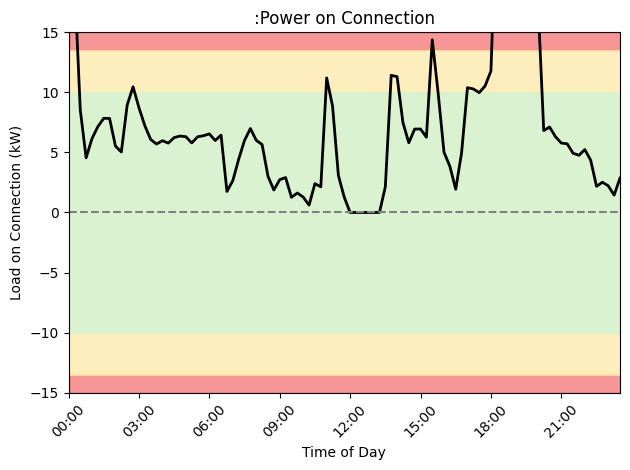

In [15]:
functions_T3.plot_results_connection('./out_Tutorial_RES_Bat.csv', connection_cap = 15, critical_limit = 0.9, tolerance_limit = 0.67)

##### 2c) Bonus
Why do you think we included a summer and a winter day in each simulation step?

#### Task 3: Electrification of Assets

As part of the Energy Transition the neighbourhood has decided to disconnect from the gas network and install Air-Source Heat Pumps for each house for space heating and hot water. Furthermore, the households have switched to electric vehicles which they frequently charge at home. This has implications for the load on the connection of the neighbourhood to the grid. 

![T3_Elec_case](Graphics_T3/neighbourhood_T3_RES_Bat_Elec_case.png)

Within the new configuration file 'Tutorial_physical_congestion_RES_bat_elec_assets.yaml' models for the additional load of the heat pumps and the electric vehicles are added. Here, the number of houses can be varied with the 'houses_case' parameter in the new_settings dictionary similar to the 'Load1' model.

a) Examine the effect of electrifying assets by simulating the new situation with the code below. Compare this new situation to the previous cases. Make sure to simulate at least the given summer day (2012-07-06) and winter day (2012-02-01) for the case of electrified assets.

b) What advice would you give based on your observations to the residents that want to have a reliable electricity and heat supply while being sustainable.

In [2]:
%%capture
CONFIG_FILE = 'Tutorial_physical_congestion_RES_bat_elec_assets.yaml'
simulation_RES_Bat_elec = Simulation(CONFIG_FILE)
simulation_RES_Bat_elec.set_model_param(model_name='CSVload', parameter='file_path', value='data/load_data.txt')
simulation_RES_Bat_elec.set_model_param(model_name='CSV_pv', parameter='file_path',
                                   value='data/pv_data_Rotterdam_NL-15min.txt')
simulation_RES_Bat_elec.set_model_param(model_name='CSV_wind', parameter='file_path', value='data/winddata_NL.txt')

simulation_RES_Bat_elec.set_model_param(model_name='CSVloadEV', parameter='file_path', value='data/10_EVs_2012_synthetic.csv')

simulation_RES_Bat_elec.set_model_param(model_name='CSVloadHP', parameter='file_path', value='data/hp_profiles_10h_kW.csv')

new_settings = {'Wind1': {'p_rated': 10},
                'Load1': {'houses': 10},
                'Load_HP1': {'houses_case': 10},
                'Load_EV1': {'houses_case': 10},
                'PV1': {'cap': 20000},
                'Battery1': {'max_p': 40, 'min_p': -40, 'soc_min': 10, 'soc_max': 90},
                'Controller1': {'max_p': 40},
                'Grid1':{'connection_capacity' : 15, 'tolerance_limit': 0.67, 'critical_limit': 0.9}
                }

simulation_RES_Bat_elec.edit_models(new_settings)

# you can switch between the selected days 2012-02-01 and 2012-07-06 by changing the date in the two lines below for better readibility it is advised to keep the observed time slot at 1 day
simulation_RES_Bat_elec.set_scenario_param('start_time', '2012-02-01 00:00:00')
simulation_RES_Bat_elec.set_scenario_param('end_time', '2012-02-01 23:45:00')

# run the simulation
simulation_RES_Bat_elec.run()

2025-05-19 12:45:11.707 | INFO     | mosaik.scenario:start:311 - Starting "Collector" as "Collector-0" ...
2025-05-19 12:45:13.110 | INFO     | mosaik.scenario:start:311 - Starting "CSVload" as "CSVload-0" ...
2025-05-19 12:45:13.222 | INFO     | mosaik.scenario:start:311 - Starting "CSVloadEV" as "CSVloadEV-0" ...
2025-05-19 12:45:13.334 | INFO     | mosaik.scenario:start:311 - Starting "CSVloadHP" as "CSVloadHP-0" ...
2025-05-19 12:45:13.446 | INFO     | mosaik.scenario:start:311 - Starting "CSV_pv" as "CSV_pv-0" ...
2025-05-19 12:45:13.542 | INFO     | mosaik.scenario:start:311 - Starting "CSV_wind" as "CSV_wind-0" ...
2025-05-19 12:45:13.638 | INFO     | mosaik.scenario:start:311 - Starting "Grid1" as "Grid1-0" ...
2025-05-19 12:45:13.638 | INFO     | mosaik.scenario:start:311 - Starting "Load1" as "Load1-0" ...
2025-05-19 12:45:13.654 | INFO     | mosaik.scenario:start:311 - Starting "Load_EV1" as "Load_EV1-0" ...
2025-05-19 12:45:13.654 | INFO     | mosaik.scenario:start:311 - St

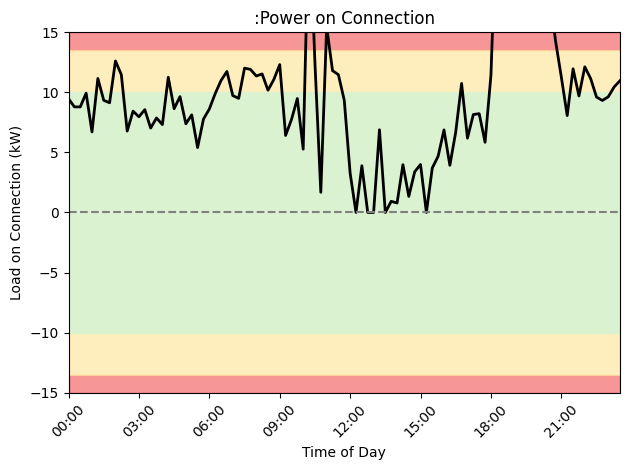

In [3]:
functions_T3.plot_results_connection('./out_Tutorial_bat_elec_assets.csv', connection_cap = 15, critical_limit = 0.9, tolerance_limit = 0.67)

### Task 4: Control Mechanism for Electrified Assets

The electrified assets namely the heat pump and the EV are assumed to be flexible loads in this exercise. This entails that the consumption does not necessarily need to happen at a certain point in time but rather within a time frame. To avoid overloading the connection to the grid each house implements a controller for their electrified assets.

a) Run the code below to simulate the new simulation for the summer day and the winter day. Compare the results with task 3. Feel free to also simulate other days. What impact does the control mechanism have?

b) How do you suspect the control mechanism works?

In [22]:
%%capture
CONFIG_FILE = 'Tutorial_physical_congestion_RES_bat_elec_loadshift.yaml'
simulation_RES_Bat_elec_loadshift = Simulation(CONFIG_FILE)
simulation_RES_Bat_elec_loadshift.set_model_param(model_name='CSVload', parameter='file_path', value='data/load_data.txt')
simulation_RES_Bat_elec_loadshift.set_model_param(model_name='CSV_pv', parameter='file_path',
                                   value='data/pv_data_Rotterdam_NL-15min.txt')
simulation_RES_Bat_elec_loadshift.set_model_param(model_name='CSV_wind', parameter='file_path', value='data/winddata_NL.txt')

simulation_RES_Bat_elec_loadshift.set_model_param(model_name='CSVloadEV', parameter='file_path', value='data/10_EVs_2012_synthetic.csv')

simulation_RES_Bat_elec_loadshift.set_model_param(model_name='CSVloadHP', parameter='file_path', value='data/hp_profiles_10h_kW.csv')

new_settings = {'Wind1': {'p_rated': 10},
                'Load1': {'houses': 10},
                'Load_HP1': {'houses_case': 10},
                'Load_EV1': {'houses_case': 10},
                'PV1': {'cap': 20000},
                'Battery1': {'max_p': 40, 'min_p': -40, 'soc_min': 10, 'soc_max': 90},
                'Grid1':{'connection_capacity' : 15, 'tolerance_limit': 0.67, 'critical_limit': 0.9},
                'Controller1': {'load_shift_active' : True}
                }

simulation_RES_Bat_elec_loadshift.edit_models(new_settings)

# you can switch between the selected days 2012-02-01 and 2012-07-06 by changing the date in the two lines below for better readibility it is advised to keep the observed time slot at 1 day
simulation_RES_Bat_elec_loadshift.set_scenario_param('start_time', '2012-02-01 00:00:00')
simulation_RES_Bat_elec_loadshift.set_scenario_param('end_time', '2012-02-01 23:45:00')

# run the simulation
simulation_RES_Bat_elec_loadshift.run()

2025-03-14 10:11:40.736 | INFO     | mosaik.scenario:start:311 - Starting "Collector" as "Collector-0" ...
2025-03-14 10:11:41.655 | INFO     | mosaik.scenario:start:311 - Starting "CSVload" as "CSVload-0" ...
2025-03-14 10:11:41.764 | INFO     | mosaik.scenario:start:311 - Starting "CSVloadEV" as "CSVloadEV-0" ...
2025-03-14 10:11:41.865 | INFO     | mosaik.scenario:start:311 - Starting "CSVloadHP" as "CSVloadHP-0" ...
2025-03-14 10:11:41.979 | INFO     | mosaik.scenario:start:311 - Starting "CSV_pv" as "CSV_pv-0" ...
2025-03-14 10:11:42.091 | INFO     | mosaik.scenario:start:311 - Starting "CSV_wind" as "CSV_wind-0" ...
2025-03-14 10:11:42.202 | INFO     | mosaik.scenario:start:311 - Starting "Grid1" as "Grid1-0" ...
2025-03-14 10:11:42.203 | INFO     | mosaik.scenario:start:311 - Starting "Load1" as "Load1-0" ...
2025-03-14 10:11:42.205 | INFO     | mosaik.scenario:start:311 - Starting "Load_EV1" as "Load_EV1-0" ...
2025-03-14 10:11:42.206 | INFO     | mosaik.scenario:start:311 - St

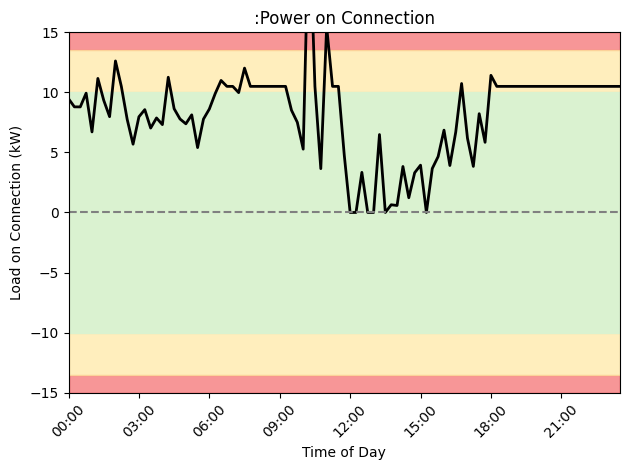

In [23]:
functions_T3.plot_results_connection('./out_Tutorial_bat_elec_assets_load_shift.csv', connection_cap = 15, critical_limit = 0.9, tolerance_limit = 0.67)